# Starter cell 
## Run this cell first to enable working with this notebook

In [1]:
# Starter cell: make repo root importable, then run bootstrap
import sys
from pathlib import Path

# If running a notebook inside scripts/, cwd is .../perch-scale-bird-weights/scripts
# -> parent() is the repo root. If your notebooks are deeper, bump parents[2], etc.
ROOT = Path.cwd()
for _ in range(5):       # walk up to 5 levels until we find the repo
    if (ROOT / ".git").exists() or (ROOT / "README.md").exists():
        break
    ROOT = ROOT.parent

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))


# Generate Figure 3 - Example of one day of perch-scale data

## Panels A + B

(36468, 2)
Number of stable weights: 1462
Mean value of stable weights: 16.394860465116277
Median value of stable weights: 19.129
Mode value of stable weights: [19.018 19.545]

Number of stable weights (filtered): 1224
Mean value of stable weights (filtered): 19.2041658496732
Median value of stable weights (filtered): 19.198999999999998
Mode value of stable weights (filtered): [18.99  19.162 19.213 19.223]

Mode weight of whole data: 0.00g
Median weight of whole data: 0.00g
Mean weight of whole data: 6.80g


Mode weight of filtered data: 19.05g
Median weight of filtered data: 19.21g
Mean weight of filtered data: 19.20g

Histogram bin size: 0.1


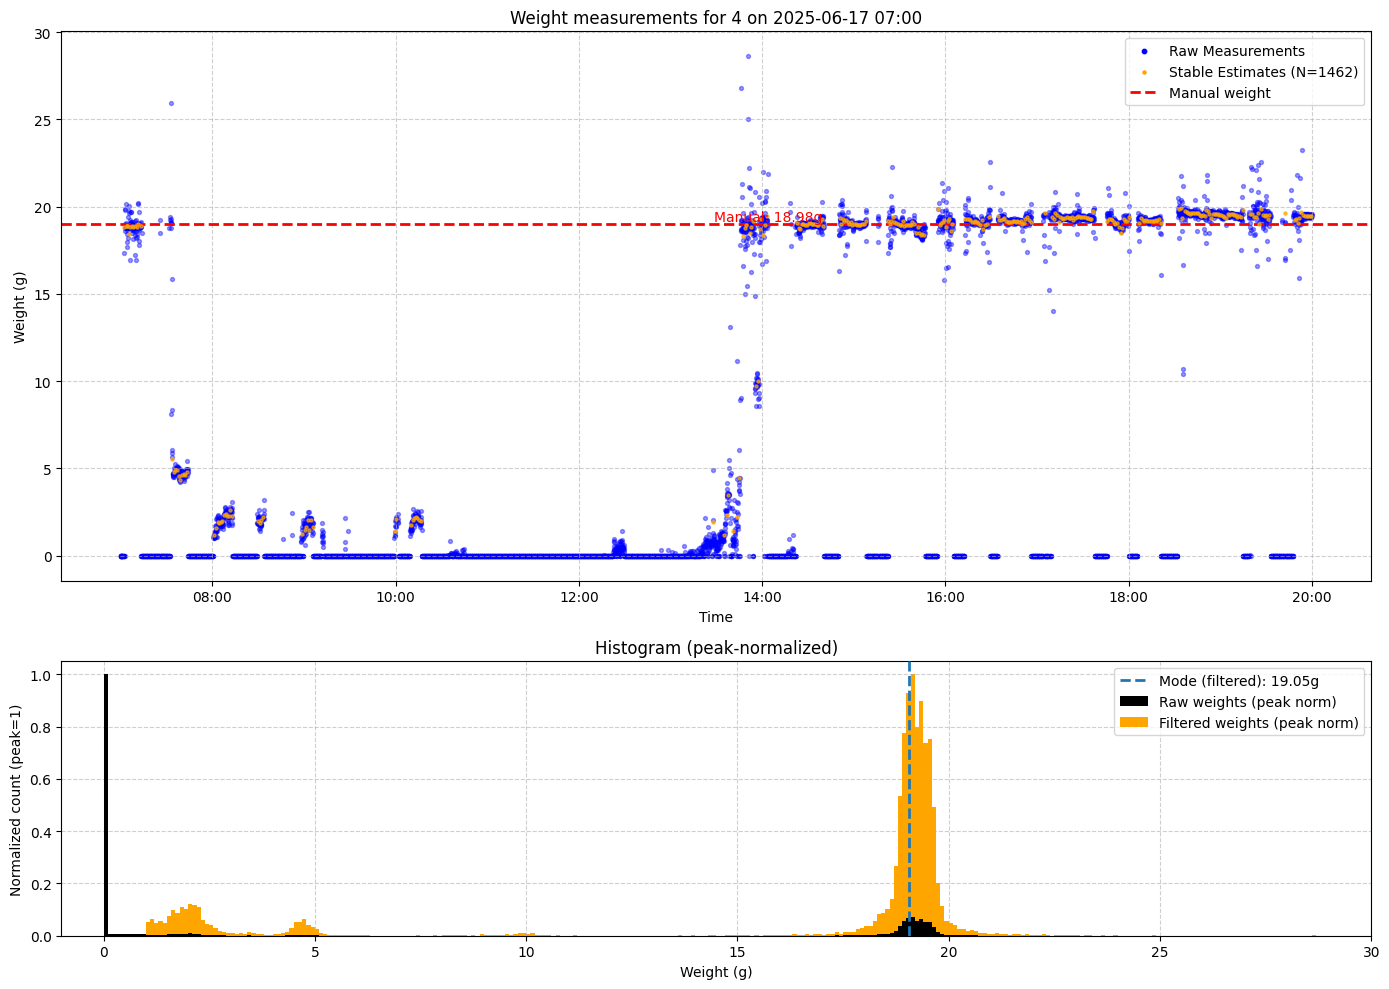

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from matplotlib import dates as mdates
# from pipeline import read_timeseries
from analyze_reliable_weight import calc_reliable_measure
from scripts.helpers import read_timeseries
# --- repo paths ---
from scripts import _paths as P

# --- User adjustable parameters ---
bird_name = 4  # replaced with bird_id of 4
# resolve file under data/birds/, prefer .csv.gz then .csv
def _bird_file(bird_id: str) -> Path:
    base = P.BIRDS / f"bird_{bird_id}_weight_report.csv"
    gz = base.with_suffix(".csv.gz")
    return gz if gz.exists() else base

weight_report_csv = _bird_file(bird_name)  # Path to data/birds/bird_4.(csv.gz|csv)
weights_file = P.META / "daily_manual_weights.csv"     # data/metadata/weights.csv

start_date = '2025-06-17 07:00'
end_date   = '2025-06-17 20:00'
start_time = None
end_time   = None
low_thrd = 0
high_thrd = 30
win_size = 10
step = 10
std_percentile = None
weight_fraction = 0.09
raw_downsample = 5
rel_downsample = 5
figsize = (14, 10)  # Double height for two subplots
# --- End user parameters ---

# Read timeseries data for the day
df = read_timeseries(
    weight_report_csv,
    low_thrd=low_thrd,
    high_thrd=high_thrd,
    start_date=start_date,
    end_date=end_date,
    start_time=start_time,
    end_time=end_time
)
if df.empty:
    print("No data found for the specified day.")
    raise SystemExit
print(df.shape)

# Read manual weights
weights_df = pd.read_csv(weights_file, index_col=0)
if start_date is not None:
    manual_weight = weights_df.loc[bird_name, pd.to_datetime(start_date).strftime('%Y-%m-%d')]
else:
    start_date = df['Time'].dt.date.min() + pd.Timedelta(days=1)
    end_date = df['Time'].dt.date.max()
    manual_weight = weights_df.loc[bird_name, pd.to_datetime(start_date).strftime('%Y-%m-%d')]

# Calculate reliable weights, use default parameters
rel = calc_reliable_measure(
    df[df['weight'] > 1],  # Filter out zero weights
    win_size=win_size,
    step=step,
    std_percentile=std_percentile,
    weight_fraction=weight_fraction,
    tolerance_fraction=0.3,
    reference_weight=manual_weight
)
print(f"Number of stable weights: {len(rel)}")
print(f"Mean value of stable weights: {rel['Weight'].mean() if not rel.empty else 'N/A'}")
print(f"Median value of stable weights: {rel['Weight'].median() if not rel.empty else 'N/A'}")
print(f"Mode value of stable weights: {rel['Weight'].mode().values if not rel.empty else 'N/A'}\n")

df_filtered = df[(df['weight'] > 0.7*manual_weight) & (df['weight'] < 1.3*manual_weight)]
rel_filtered = calc_reliable_measure(
    df_filtered,
    win_size=win_size,
    step=step,
    std_percentile=std_percentile,
    weight_fraction=weight_fraction,
    tolerance_fraction=0.3,
    reference_weight=manual_weight
)
print(f"Number of stable weights (filtered): {len(rel_filtered)}")
print(f"Mean value of stable weights (filtered): {rel_filtered['Weight'].mean() if not rel_filtered.empty else 'N/A'}")
print(f"Median value of stable weights (filtered): {rel_filtered['Weight'].median() if not rel_filtered.empty else 'N/A'}")
print(f"Mode value of stable weights (filtered): {rel_filtered['Weight'].mode().values if not rel_filtered.empty else 'N/A'}")

# print mean, mode and median of unfiltered data (df)
mode_weight = df['weight'].mode()[0] if not df['weight'].mode().empty else None
median_weight = df['weight'].median() if not df['weight'].empty else None
mean_weight = df['weight'].mean() if not df['weight'].empty else None
print(f"\nMode weight of whole data: {mode_weight:.2f}g")
print(f"Median weight of whole data: {median_weight:.2f}g")
print(f"Mean weight of whole data: {mean_weight:.2f}g\n")

# print mean, mode and median of filtered data
mode_weight_f = df_filtered['weight'].mode()[0] if not df_filtered['weight'].mode().empty else None
median_weight_f = df_filtered['weight'].median() if not df_filtered['weight'].empty else None
mean_weight_f = df_filtered['weight'].mean() if not df_filtered['weight'].empty else None
print(f"\nMode weight of filtered data: {mode_weight_f:.2f}g")
print(f"Median weight of filtered data: {median_weight_f:.2f}g")
print(f"Mean weight of filtered data: {mean_weight_f:.2f}g\n")

# Plot: scatter and histogram as subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=False, gridspec_kw={'height_ratios': [2, 1]})

# --- Scatter plot --- with additional single point for label visibility
df_plot = df.iloc[::raw_downsample]
ax1.scatter(df_plot['Time'], df_plot['weight'], alpha=0.4, color='blue', s=8)
ax1.scatter(df_plot.iloc[1]['Time'], df_plot.iloc[1]['weight'], alpha=1, label='Raw Measurements', color='blue', s=10)

rel_plot = rel.iloc[::rel_downsample]
ax1.scatter(pd.to_datetime(rel_plot['Time']), rel_plot['Weight'], color='orange', s=5, alpha=0.7, zorder=3)
ax1.scatter(pd.to_datetime(rel_plot.iloc[1]['Time']), rel_plot.iloc[1]['Weight'], color='orange', s=5, alpha=1, label=f'Stable Estimates (N={len(rel)})', zorder=3)

# Manual weight line
if not pd.isna(manual_weight):
    ax1.axhline(manual_weight, color='red', linestyle='--', linewidth=2, label='Manual weight')
    ax1.text(df['Time'].iloc[len(df)//2], manual_weight, f'Manual: {manual_weight:.2f}g', color='red', va='bottom')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_xlabel('Time')
ax1.set_ylabel('Weight (g)')
ax1.set_title(f'Weight measurements for {bird_name} on {start_date}')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# --- Histogram with peak normalization ---
weights_for_hist = df['weight'].dropna()
df_hist_filtered = df[df['weight'] > 1]
weights_filtered = df_hist_filtered['weight'].dropna()

bins = np.arange(min(weights_for_hist.min(), weights_filtered.min()),
                 max(weights_for_hist.max(), weights_filtered.max()) + 0.1, 0.1)
print(f"Histogram bin size: {bins[1] - bins[0]}")

raw_counts, _ = np.histogram(weights_for_hist, bins=bins)
raw_counts = raw_counts / raw_counts.max()

filtered_counts, _ = np.histogram(weights_filtered, bins=bins)
filtered_counts = filtered_counts / filtered_counts.max()

bin_centers = (bins[:-1] + bins[1:]) / 2
ax2.bar(bin_centers, raw_counts, color='black', label='Raw weights (peak norm)', width=0.1, zorder=2)
ax2.bar(bin_centers, filtered_counts, color='orange', label='Filtered weights (peak norm)', width=0.1, zorder=1)
ax2.set_xlim(-1, 30)
ax2.set_xlabel('Weight (g)')
ax2.set_ylabel('Normalized count (peak=1)')
ax2.set_title('Histogram (peak-normalized)')

if not weights_filtered.empty:
    mode_filtered = weights_filtered.mode().iloc[0]
    ax2.axvline(mode_filtered, color='#1f77b4', linestyle='--', linewidth=2,
                label=f'Mode (filtered): {mode_filtered:.2f}g', zorder=10)

ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

fig_save_name = P.FIGS / f"single_day_{bird_name}_17_06_25.svg"
plt.savefig(fig_save_name, bbox_inches='tight', dpi=300, format='svg')

plt.show()
